In [ ]:
################################
# add values based on time coord
# thanks chat
################################

import numpy as np
import pandas as pd
import xarray as xr

# Create a time range
time = pd.date_range('2020-01-01', periods=10, freq='D')

# Create an initial xarray Dataset
ds = xr.Dataset(
    {
        'temperature': (['time'], np.random.rand(len(time)) * 10)  # Random temperature values
    },
    coords={'time': time}
)

# Define a function that depends on time
def temperature_trend(time):
    return 0.5 * (time - np.datetime64('2020-01-01')).astype('timedelta64[D]').astype(int)

# Apply this function to each time point
trend_values = temperature_trend(ds.time.values)

# Add the new values to the dataset
ds['temperature_trend'] = ('time', trend_values)

print(ds)

ds.close()

In [ ]:
#################################
# add values based on x coord
# should be similar to above code
# thanks chat
#################################

import numpy as np
import pandas as pd
import xarray as xr

# Create a time range
time = pd.date_range('2020-01-01', periods=10, freq='D')
# Create an x range
x = np.linspace(0, 10, 5)

# Create an initial xarray Dataset
ds = xr.Dataset(
    {
        'temperature': (['time', 'x'], np.random.rand(len(time), len(x)) * 10)  # Random temperature values
    },
    coords={'time': time, 'x': x}
)

# Define a function that depends on the x coordinate
def elevation(x):
    return 2 * x + 5

# Apply the function to the x coordinate
elevation_values = elevation(ds.x.values)

# Broadcast the elevation values to match the dimensions of the dataset
elevation_broadcasted = np.broadcast_to(elevation_values, (len(ds.time), len(ds.x)))

# Add the new values to the dataset
ds['elevation'] = (['time', 'x'], elevation_broadcasted)

print(ds)

ds.close()

In [ ]:
import numpy as np
import xarray as xr

def main():
    vector_file = "January/results/video_capture_2024-01-02_09-44-20_velocimetry_results.nc"

    ds = xr.open_dataset(vector_file)

    spac_loc = spacial_location_wrapper(ds.y.values)
    spac_loc = np.broadcast_to(spac_loc, (len(ds.time), len(ds.y)))

    ds['spacial_location'] = (['time', 'y'], spac_loc)

    print(ds)

def spacial_location(y, m, subdiv):
    if y < m + subdiv:
        return 0
    elif (y >= m + subdiv) and (y < m + 2 * subdiv):
        return 1
    elif (y >= m + subdiv) and (y < m + 3 * subdiv):
        return 2
    elif (y >= m + subdiv) and (y < m + 4 * subdiv):
        return 3
    else:
        return 4

def spacial_location_wrapper(y_vals):
    maximum = max(y_vals)
    minimum = min(y_vals)
    subdiv = (maximum - minimum) / 5

    spac_loc = []
    for y in y_vals:
        spac_loc.append(spacial_location(y, minimum, subdiv))
    return spac_loc

main()

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# vector_file = "January/results/video_capture_2024-01-02_09-44-20_velocimetry_results.nc"
vector_file = "nc_old/video_capture_2024-05-17_13-49-18_velocimetry_results.nc"
ds = xr.open_dataset(vector_file)

name = vector_file.split('/')[-1].rsplit('_', maxsplit=2)[0]
year, month, day = name.split('_')[2].split('-')
hour, minute, second = name.split('_')[3].split('-')

rounded_minute = 15 * round(int(minute) / 15)
minute = 0 if rounded_minute == 60 else rounded_minute

dt = datetime(int(year), int(month), int(day), int(hour), minute, int(second))
dt_utc = (dt + timedelta(hours=7)).replace(second=0)

# date = f"{dt_utc.year}-{dt_utc.month:02}-{dt_utc.day:02} {dt_utc.hour:02}:{dt_utc.minute:02}:00"
date = dt_utc.strftime('%Y-%m-%d %H:%M:%S')

df = pd.read_csv('LR_WaterLab_AA_SourceID_1_QC_0_Year_2024.csv')
df = df[['DateTimeUTC', 'Discharge_cms']]
df = df[df.Discharge_cms >= 0]
print(df)

print(date in df.DateTimeUTC.values)
if dt_utc in df.DateTimeUTC.values:
    discharge_cms = df[df.DateTimeUTC == date].Discharge_cms.values[0]
else:
    discharge_cms = np.nan

discharge = xr.DataArray(
    data=discharge_cms * np.ones_like(ds['time']),
    dims=['time'],
    coords={'time': ds['time']}
)
ds['sun_altitude'] = discharge


In [8]:
import pandas as pd

df = pd.read_csv('LR_WaterLab_AA_SourceID_1_QC_0_Year_2024.csv')
df[df.pH > 15]

df.pH = [value if value < 15 else value / 10 for value in df.pH.values]
df.pH

0        8.37
1        8.37
2        8.36
3        8.36
4        8.36
         ... 
15167    8.08
15168    8.07
15169    8.07
15170    8.07
15171    8.07
Name: pH, Length: 15172, dtype: float64

In [1]:

import requests
import sys

import csv
import codecs
        

response = requests.request("GET", "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/41.739034%2C%20-111.795742/2024-05-01/2024-05-31?unitGroup=us&include=hours&key=4KJRENQNAVB2P7EWEP82W9B3L&contentType=csv")
if response.status_code!=200:
  print('Unexpected Status code: ', response.status_code)
  sys.exit()  


# Parse the results as CSV
CSVText = csv.reader(response.text.splitlines(), delimiter=',',quotechar='"')
        
       
               

output_file = 'May_weather.csv'
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    for row in CSVText:
        writer.writerow(row)

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('January_weather.csv')
print(df.columns)
df

Index(['name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')


,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"41.739034, -111.795742",2024-01-01T00:00:00,25.1,25.1,20.1,80.83,0.0,0,NaN,0.0,...,1024.5,0.0,6.3,0,0.0,0,10,Clear,clear-night,"UCC08,KOGD,72479694128,72575024126,99999904138..."
1,"41.739034, -111.795742",2024-01-01T01:00:00,24.3,24.3,19.2,80.71,0.0,0,NaN,0.0,...,1024.3,0.0,6.3,0,0.0,0,10,Clear,clear-night,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
2,"41.739034, -111.795742",2024-01-01T02:00:00,21.9,17.4,17.1,81.48,0.0,0,NaN,0.0,...,1024.3,0.0,6.3,0,0.0,0,10,Clear,clear-night,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
3,"41.739034, -111.795742",2024-01-01T03:00:00,21.0,16.3,16.1,81.11,0.0,0,NaN,0.0,...,1024.8,98.0,0.1,0,0.0,0,10,Overcast,fog,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
4,"41.739034, -111.795742",2024-01-01T04:00:00,21.0,21.0,17.1,84.60,0.0,0,NaN,0.0,...,1024.9,98.0,0.1,0,0.0,0,10,Overcast,fog,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,"41.739034, -111.795742",2024-01-31T19:00:00,30.2,30.2,25.1,81.07,0.0,0,NaN,0.0,...,1018.0,0.0,6.9,0,0.0,0,10,Clear,clear-night,"UCC08,KOGD,72479694128,KHIF,72575024126,999999..."
740,"41.739034, -111.795742",2024-01-31T20:00:00,27.3,27.3,23.1,83.88,0.0,0,NaN,0.0,...,1017.9,0.0,3.8,0,0.0,0,10,Clear,clear-night,"UCC08,KOGD,72479694128,KHIF,72575024126,999999..."
741,"41.739034, -111.795742",2024-01-31T21:00:00,23.4,18.8,19.3,84.01,0.0,0,NaN,0.0,...,1018.0,97.2,0.2,0,0.0,0,10,Overcast,fog,"UCC08,KOGD,72479694128,KHIF,72575024126,999999..."
742,"41.739034, -111.795742",2024-01-31T22:00:00,22.1,22.1,19.2,88.46,0.0,0,NaN,0.0,...,1016.1,98.0,0.1,0,0.0,0,10,Overcast,fog,"UCC08,KOGD,72479694128,72575024126,99999904138..."


In [40]:
df.head(15)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"41.739034, -111.795742",2024-01-01T00:00:00,25.1,25.1,20.1,80.83,0.0,0,NaN,0.0,...,1024.5,0.0,6.3,0,0.0,0,10,Clear,clear-night,"UCC08,KOGD,72479694128,72575024126,99999904138..."
1,"41.739034, -111.795742",2024-01-01T01:00:00,24.3,24.3,19.2,80.71,0.0,0,NaN,0.0,...,1024.3,0.0,6.3,0,0.0,0,10,Clear,clear-night,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
2,"41.739034, -111.795742",2024-01-01T02:00:00,21.9,17.4,17.1,81.48,0.0,0,NaN,0.0,...,1024.3,0.0,6.3,0,0.0,0,10,Clear,clear-night,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
3,"41.739034, -111.795742",2024-01-01T03:00:00,21.0,16.3,16.1,81.11,0.0,0,NaN,0.0,...,1024.8,98.0,0.1,0,0.0,0,10,Overcast,fog,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
4,"41.739034, -111.795742",2024-01-01T04:00:00,21.0,21.0,17.1,84.60,0.0,0,NaN,0.0,...,1024.9,98.0,0.1,0,0.0,0,10,Overcast,fog,"KOGD,72479694128,72575024126,99999904138,KLGU,..."
5,"41.739034, -111.795742",2024-01-01T05:00:00,20.2,20.2,16.1,84.15,0.0,0,NaN,0.0,...,1025.4,98.0,0.1,0,0.0,0,10,Overcast,fog,"UCC08,KOGD,72479694128,72575024126,99999904138..."
6,"41.739034, -111.795742",2024-01-01T06:00:00,19.3,19.3,16.1,87.40,0.0,0,NaN,0.0,...,1026.2,98.0,0.1,0,0.0,0,10,Overcast,fog,"UCC08,KOGD,72479694128,72575024126,99999904138..."
7,"41.739034, -111.795742",2024-01-01T07:00:00,20.1,20.1,15.2,81.06,0.0,0,NaN,0.0,...,1026.7,98.0,0.1,0,0.0,0,10,Overcast,fog,"UCC08,KOGD,72479694128,72575024126,99999904138..."
8,"41.739034, -111.795742",2024-01-01T08:00:00,19.2,19.2,15.2,84.12,0.0,0,NaN,0.0,...,1027.1,0.0,3.8,4,0.0,0,10,Clear,clear-day,"UCC08,KOGD,72479694128,72575024126,99999904138..."
9,"41.739034, -111.795742",2024-01-01T09:00:00,20.2,20.2,16.1,84.15,0.0,0,NaN,0.0,...,1025.8,0.0,3.3,16,0.1,0,10,Clear,clear-day,"UCC08,KOGD,72479694128,72575024126,99999904138..."


<Axes: xlabel='preciptype', ylabel='Count'>

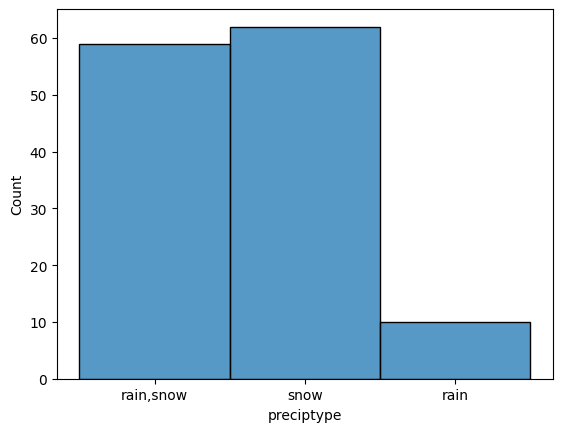

In [15]:
sns.histplot(
    data=df,
    x='preciptype'
)

<Axes: xlabel='cloudcover', ylabel='Count'>

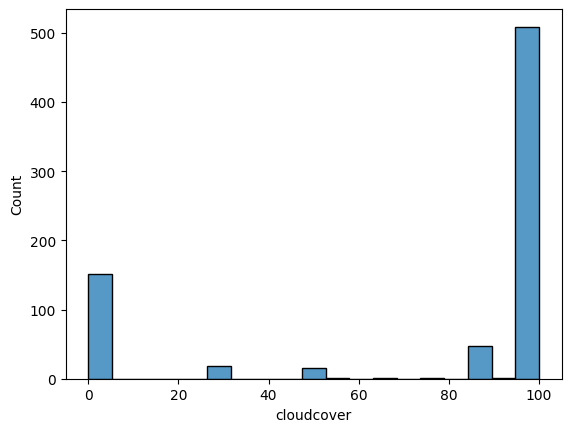

In [21]:
sns.histplot(
    data=df,
    x='cloudcover'
)

<Axes: xlabel='conditions', ylabel='Count'>

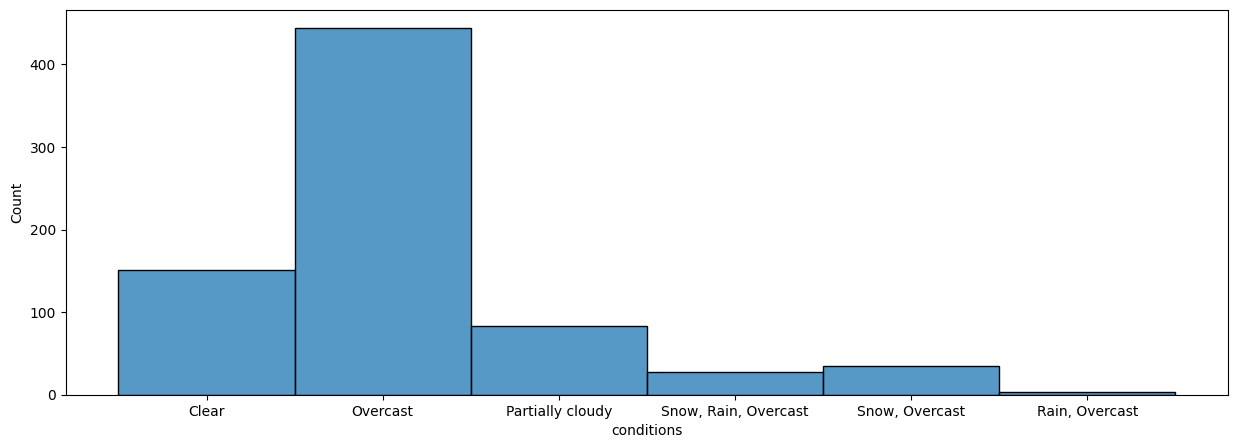

In [22]:
plt.figure(figsize=(15, 5))

sns.histplot(
    data=df,
    x='conditions'
)

<Axes: xlabel='uvindex', ylabel='Count'>

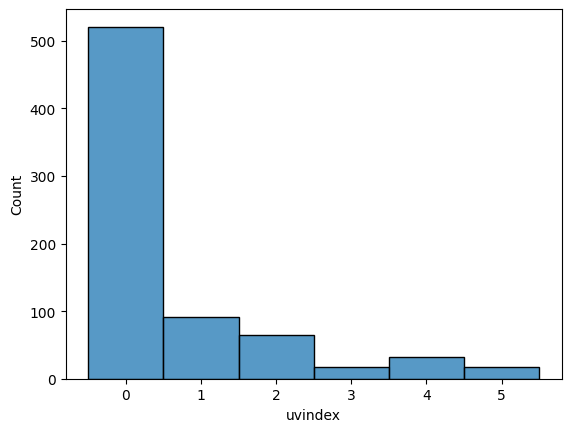

In [26]:
sns.histplot(
    data=df,
    x='uvindex',
    discrete=True
)

<Axes: xlabel='windgust', ylabel='Count'>

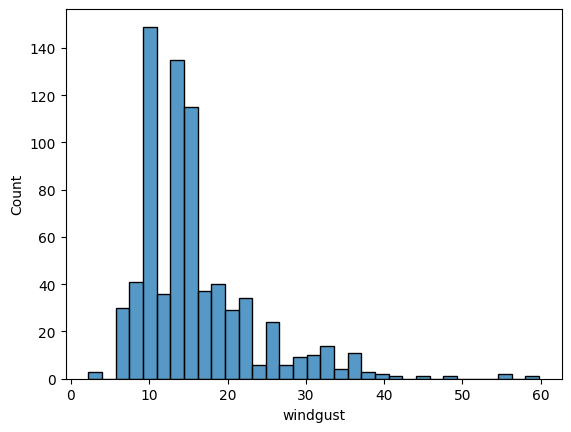

In [30]:
sns.histplot(
    data=df,
    x='windgust',
)

<Axes: xlabel='windspeed', ylabel='Count'>

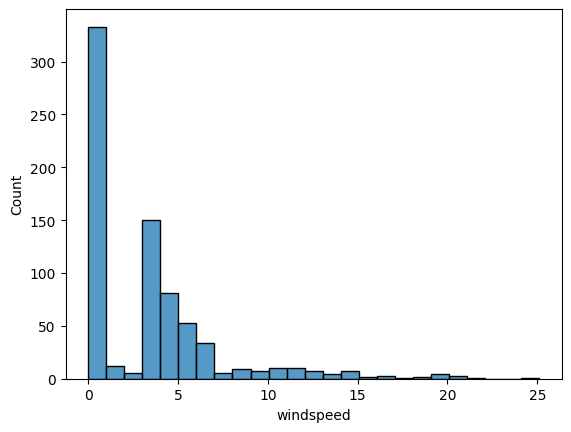

In [31]:
sns.histplot(
    data=df,
    x='windspeed',
)

<Axes: xlabel='winddir', ylabel='Count'>

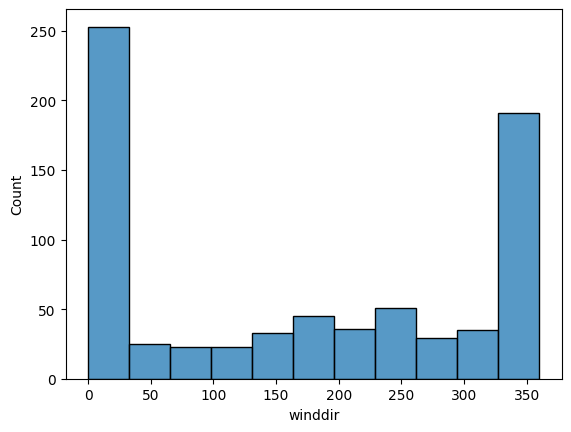

In [32]:
sns.histplot(
    data=df,
    x='winddir',
)

<Axes: xlabel='visibility', ylabel='Count'>

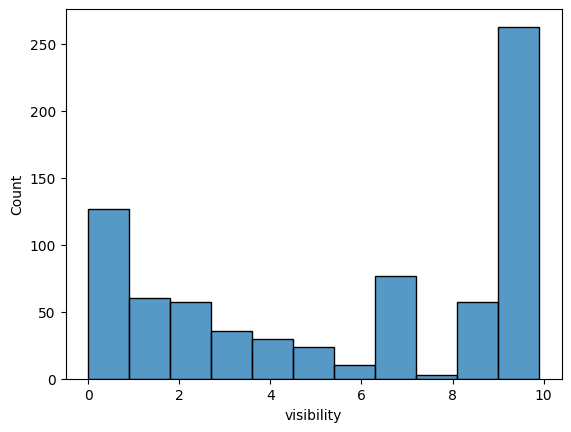

In [33]:
sns.histplot(
    data=df,
    x='visibility'
)

<Axes: xlabel='solarradiation', ylabel='Count'>

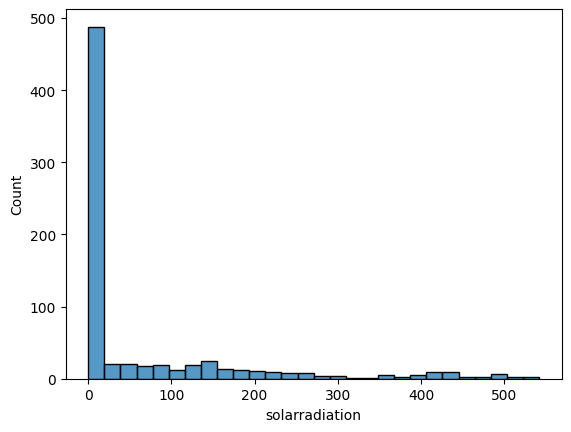

In [35]:
sns.histplot(
    data=df,
    x='solarradiation',
)

<Axes: xlabel='solarenergy', ylabel='Count'>

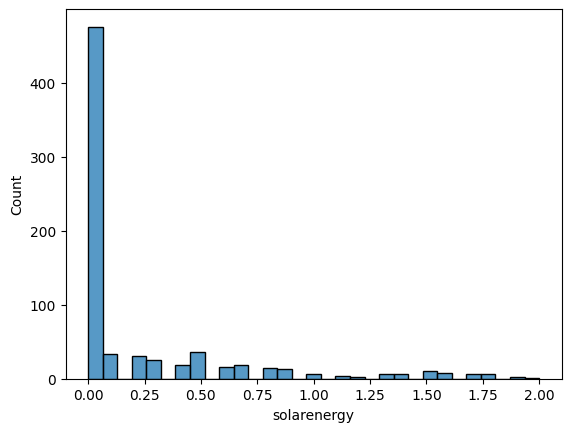

In [36]:
sns.histplot(
    data=df,
    x='solarenergy',
)